In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from src import utils, nmf_utils, lda_utils
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
#nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

from collections import Counter
from operator import itemgetter

# NMF - Wall Street Forum

In [4]:
def bow_vectorizer(docs_raw, min_doc_freq, max_doc_freq, max_feats, ngram_rng):
    '''
    
    Args:
        
    Return:
    
    '''
    vectorizer = CountVectorizer(min_df=min_doc_freq, max_df=max_doc_freq, max_features=max_feats, ngram_range=ngram_rng)
    docs_vectorized = vectorizer.fit_transform(docs_raw)
    return docs_vectorized, vectorizer


In [5]:
def tfidf_vectorizer(docs_raw, min_doc_freq, max_doc_freq, max_feats, ngram_rng):
    '''
    
    Args:
        
    Return:
    
    '''
    vectorizer = TfidfVectorizer(min_df=min_doc_freq, max_df=max_doc_freq, max_features=max_feats, ngram_range=ngram_rng)
    docs_vectorized = vectorizer.fit_transform(docs_raw)
    return docs_vectorized, vectorizer

In [6]:
def print_topics(model, count_vectorizer, n_top_words):
    '''
   
    Args:
    
        
    Return:
    
        
    '''
    
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        top_words_arr = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join(top_words_arr))

In [27]:
# wsm = Wall Street Market
# append_to_stopwords = ['wsm']

stop_words = stopwords.words("english")# .append(append_to_stopwords)
stopwords_dict = Counter(stop_words)


def tokenize_lemmatize(text):
    '''
    
    
    Args:
        comment (str) : Content of the author's post in Wall Street Market.
        
    Return:
        lem_tokens (arr) : The cleaned, tokenized and lemmetized version of comment.
        
    '''
    
    
    
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords_dict]
    
    wordnet_lemma = nltk.WordNetLemmatizer()
    lem_tokens = [wordnet_lemma.lemmatize(t) for t in tokens]
    
    return lem_tokens

## Import Dataset and Model Inputs

In [28]:
wallstreet = pd.read_csv('data/wallstreet_master.csv')

In [29]:
# Must perform again b/c tokens are transformed to strings when saved to "data/wallstreet_master.csv" in "wallstreet_feat_eng_eda.ipynb"
wallstreet['tokens_for_nmf'] = wallstreet['cleaned_text'].apply(tokenize_lemmatize)

In [31]:
wallstreet.head()

,postID,threadID,threadTitle,subforum,authorName,postAuthorMembership,authorReputation,postSequence,flatContent,contentWithHTMLTag,post_date_dt,author_join_date,num_days_member_when_posted,wordcloud_text,cleaned_text,lemmatized_tokens,tokens_for_nmf
0,6,5,Hi,Introductions,Punka421,New member,-3,1,\nJust thought I'd introduce myself. I am new ...,"<div class=""entry-content"">\n<p>Just thought I...",2016-10-26 13:58:36,2016-10-26 00:00:00,0.0,thought id introduce new communities trying le...,just thought id introduce myself i am new to ...,"['thought', 'id', 'introduce', 'new', 'communi...","[thought, id, introduce, new, community, tryin..."
1,7,5,Hi,Introductions,WSM,Administrator,66,2,\nHello Nice to see you here!Regards\n,"<div class=""entry-content"">\n<p>Hello <img alt...",2016-10-26 14:04:04,2016-10-02 00:00:00,24.0,hello nice see hereregards,hello nice to see you hereregards,"['hello', 'nice', 'see', 'hereregards']","[hello, nice, see, hereregards]"
2,8,6,WSM Updates - Changelog (Page 1 of 4),Announcements,WSM,Administrator,74,1,\nHello everyone.I would like to tell you that...,"<div class=""entry-content"">\n<p>Hello everyone...",2016-10-26 16:54:27,2016-10-02 00:00:00,24.0,hello everyonei would like tell weve implement...,hello everyonei would like to tell you that w...,"['hello', 'everyonei', 'would', 'like', 'tell'...","[hello, everyonei, would, like, tell, weve, im..."
3,11,5,Hi,Introductions,Estrazy,Banned,0,3,\nHello Punka! nice to meet you!As you asked h...,"<div class=""entry-content"">\n<p>Hello Punka! n...",2016-10-27 14:00:16,2016-10-27 00:00:00,0.0,hello punka nice meet youas asked stay secure ...,hello punka nice to meet youas you asked how ...,"['hello', 'punka', 'nice', 'meet', 'youas', 'a...","[hello, punka, nice, meet, youas, asked, stay,..."
4,13,6,WSM Updates - Changelog (Page 1 of 4),Announcements,WSM,Administrator,74,2,"\nChangelog from Wednesday, 2nd November 2016F...","<div class=""entry-content"">\n<h5>Changelog fro...",2016-11-02 15:42:27,2016-10-02 00:00:00,31.0,changelog wednesday november lot small issues ...,changelog from wednesday november a lot of ...,"['changelog', 'wednesday', 'november', 'lot', ...","[changelog, wednesday, november, lot, small, i..."


In [67]:
docs_raw = wallstreet['tokens_for_nmf']

---
## Use Gensim to Identify Optimal Number of Topics

In [35]:
gensim_dict = Dictionary(docs_raw)
gensim_dict.filter_extremes(no_below=0.1, no_above=0.85, keep_n=10000)

corpus = [gensim_dict.doc2bow(doc) for doc in docs_raw]



In [62]:
num_topics_rng = list(np.arange(3, 42 + 1, 3)) 
coherence_scores = []

# NMF MODEL PARAMS
num_passes_over_training_docs = 5
gradient_desc_step = 0.1

# the "normalized" arg must equal true to be relevant.
floor_probs_for_topics = 0.005
normalize = True
num_training_docs_per_chunk = 5000

# W = topics by words
w_max_iter=300
w_stop_condition=0.0001

# H = articles by topics
h_max_iter=100
h_stop_condition=0.001
eval_every=10
random_state = 3

for num in num_topics_rng:
    nmf = Nmf(corpus=corpus, num_topics=num, id2word=gensim_dict, chunksize=num_training_docs_per_chunk,  passes=num_passes_over_training_docs, kappa=gradient_desc_step,
             normalize=normalize, minimum_probability=floor_probs_for_topics, w_max_iter=w_max_iter, w_stop_condition=w_stop_condition, h_max_iter=h_max_iter,
             h_stop_condition=h_stop_condition, eval_every=eval_every, random_state=random_state)
    
    coherence_model = CoherenceModel(model=nmf, texts=docs_raw, dictionary=gensim_dict, coherence='c_v')
    
    coherence_scores.append(round(coherence_model.get_coherence(), 5))

scores = list(zip(num_topics_rng, coherence_scores))
topics_sorted_by_co_score = sorted(scores, key=itemgetter(1), reverse=True)
print(topics_sorted_by_co_score)

[(12, 0.58383), (3, 0.58256), (21, 0.55279), (30, 0.5517), (9, 0.54829), (15, 0.54409), (18, 0.53731), (27, 0.53252), (39, 0.53201), (24, 0.52232), (42, 0.51588), (36, 0.50996), (33, 0.49448), (6, 0.48693)]


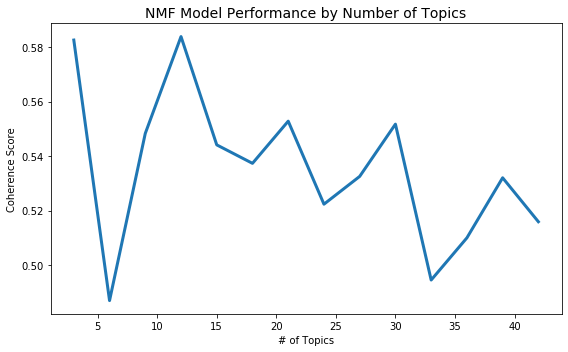

In [66]:
coherence_scores = [scores[i][1] for i in range(len(scores))]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(num_topics_rng, coherence_scores, linewidth=3)
ax.set_title('NMF Model Performance by Number of Topics', fontsize=14)
ax.set_xlabel('# of Topics')
ax.set_ylabel('Coherence Score')
plt.tight_layout();

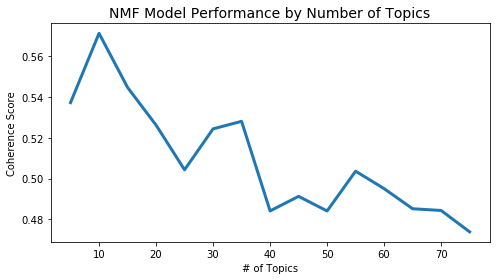

In [59]:
coherence_scores = [scores[i][1] for i in range(len(scores))]

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(num_topics_rng, coherence_scores, linewidth=3)
ax.set_title('NMF Model Performance by Number of Topics', fontsize=14)
ax.set_xlabel('# of Topics')
ax.set_ylabel('Coherence Score')
plt.tight_layout();

---
## NMF Inputs

In [69]:
lemmatized_tokens = wallstreet['lemmatized_tokens']

---
## NMF - Bag of Words 

In [72]:
# bow_docs_vectorized,  bow_vectorizer = bow_vectorizer(docs_raw, min_doc_freq, max_doc_freq, max_feats, ngram_rng)

best_num_topics = 20

bow_vectorizer = CountVectorizer(min_df=min_doc_freq, max_df=max_doc_freq, max_features=max_feats, ngram_range=ngram_rng)
bow_docs_vectorized = bow_vectorizer.fit_transform(lemmatized_tokens)
nmf_bow = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=3).fit(bow_docs_vectorized)

In [73]:
# doc_weights = nmf_bow.transform(bow_vectorizer.transform(docs_raw))

AttributeError: 'list' object has no attribute 'lower'

In [74]:
n_top_words = 10

print_topics(nmf_bow, bow_vectorizer, n_top_words)


Topic #0:
bank one account know day dont get get phished good help

Topic #1:
dont phished wsm help know bank day get get phished good help

Topic #2:
phished help get get phished wsm help phished rule get wsm help rule im

Topic #3:
account phished bank know day dont get get phished good help

Topic #4:
market vendor bank wsm help know day dont get get phished good

Topic #5:
vendor wsm help know bank day dont get get phished good help

Topic #6:
new bank offer wsm help know day dont get get phished good

Topic #7:
get help get wsm help wsm bank day dont get phished good help

Topic #8:
one need wsm help know bank day dont get get phished good

Topic #9:
need get know like vendor please dont im bank day

Topic #10:
like know good need bank day dont get get phished help

Topic #11:
good know wsm help wsm bank day dont get get phished help

Topic #12:
im phished wsm help know bank day dont get get phished good

Topic #13:
offer market bank get new wsm help im day dont get phished

Topi

---
## NMF - Tf-Idf

In [75]:
# bow_docs_vectorized,  bow_vectorizer = bow_vectorizer(docs_raw, min_doc_freq, max_doc_freq, max_feats, ngram_rng)

best_num_topics = 20

tfidf_vectorizer = TfidfVectorizer(min_df=min_doc_freq, max_df=max_doc_freq, max_features=max_feats, ngram_range=ngram_rng)
tfidf_docs_vectorized = tfidf_vectorizer.fit_transform(lemmatized_tokens)
nmf_tfidf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=3).fit(tfidf_docs_vectorized)

In [76]:
n_top_words = 10

print_topics(nmf_tfidf, tfidf_vectorizer, n_top_words)


Topic #0:
bank account wsm day dont get get phished good help help get

Topic #1:
phished wsm help phished rule get phished help get rule help wsm get im

Topic #2:
market phished wsm help know bank day dont get get phished good

Topic #3:
vendor wsm help know bank day dont get get phished good help

Topic #4:
know phished good wsm help bank day dont get get phished help

Topic #5:
account phished good know bank day dont get get phished help

Topic #6:
good wsm help wsm bank day dont get get phished help help get

Topic #7:
need help get wsm help know bank day dont get get phished good

Topic #8:
get help get wsm help wsm bank day dont get phished good help

Topic #9:
im phished wsm help know bank day dont get get phished good

Topic #10:
like im know dont wsm bank day get get phished good

Topic #11:
offer help get account new market know dont im please bank

Topic #12:
please phished new wsm help im bank day dont get get phished

Topic #13:
wsm wsm help bank day dont get get phished